## Package Imports ##

In [5]:
import os   # Directory Package
import warnings

#Importing Scientific computing package for python. Library that provides a multidimential array
# object, various derived objects (such as masked arrays and matrices), and an assortment of 
# routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting,
# selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random
# simulation and much more
import numpy as np

from numpy import genfromtxt

#Importing Pythons Open Source Data Analysis and manipulation library
import pandas as pd

import matplotlib.pylab as plt
from matplotlib import style

import seaborn as sns

import glob

import tensorflow as tf
import shutil

import kaggle

import random as rd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, BatchNormalization
from keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from keras.utils import to_categorical

#Importing Pythons Open Computer Vision Library that is designed to solve computer vision problems.
import cv2

from PIL import Image
from tqdm import tqdm

import pathlib  #Object-Oriented Filesystem paths functionality
                #This module offers classes representing filesystem paths.

In [ ]:
#kaggle.api.dataset_list()


## Download Dataset ##

Download the Kaggle [Fruits 360](https://www.kaggle.com/datasets/moltean/fruits) dataset

In [ ]:
#!kaggle datasets download moltean/fruits

## Unzip Data zip file ##

In [ ]:
from zipfile import ZipFile

with ZipFile("fruits.zip", mode="r") as zip_file:
    #zip_file.printdir()
    for file in zip_file.infolist():
        if file.filename.startswith('fruits-360_dataset/fruits-360/Training'):
            file.filename = file.filename.replace('fruits-360_dataset/fruits-360/Training', 'dataset/')
            #print(file.filename)
            zip_file.extract(file, path='.')
 
        elif file.filename.startswith('fruits-360_dataset/fruits-360/Test/'):
            file.filename = file.filename.replace('fruits-360_dataset/fruits-360/Test/', 'dataset/')
            #print(file.filename)
            zip_file.extract(file, path='.')            



In [25]:
IMG_SIZE = 100

X = []    # Data
Z = []    # Classification

def assign_label(img, fruit_type):
    return fruit_type

def make_train_data(fruit_type, dir): 
    for img in tqdm(os.listdir(dir)):       #tqdm shows a status bar in the jupyter environment
        label = assign_label(img, fruit_type)
        path = os.path.join(dir, img)
        try:
            img = cv2.imread(path, cv2.IMREAD_COLOR)
            #img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(np.array(img))
            Z.append(str(label))
        except cv2.error:
            print("image read and resize failed")
            

## Set up Directory Structure ##

In [26]:
root_directory = pathlib.Path(r"dataset")

#Iterating down the subtree of root directory and Creating a list of all fruit class Directories 
sub_directory_paths = list(root_directory.glob('*'))   

#for file_path in directory_paths:
#  print(file_path)

#Checking The number of directories in the list
#print(len(directory_paths))  

## Create Training Data ##
Iterate over subdirectory paths and pull each subpath out to get the basename which is used to create the class name in the first parameter (os.path.basename(subpaths)) and use that subpaths path to include the location of the image

In [27]:
for subpaths in sub_directory_paths:
    make_train_data(os.path.basename(subpaths), subpaths)

100%|██████████| 632/632 [00:00<00:00, 1908.72it/s]


## Output data for Eye Test ##

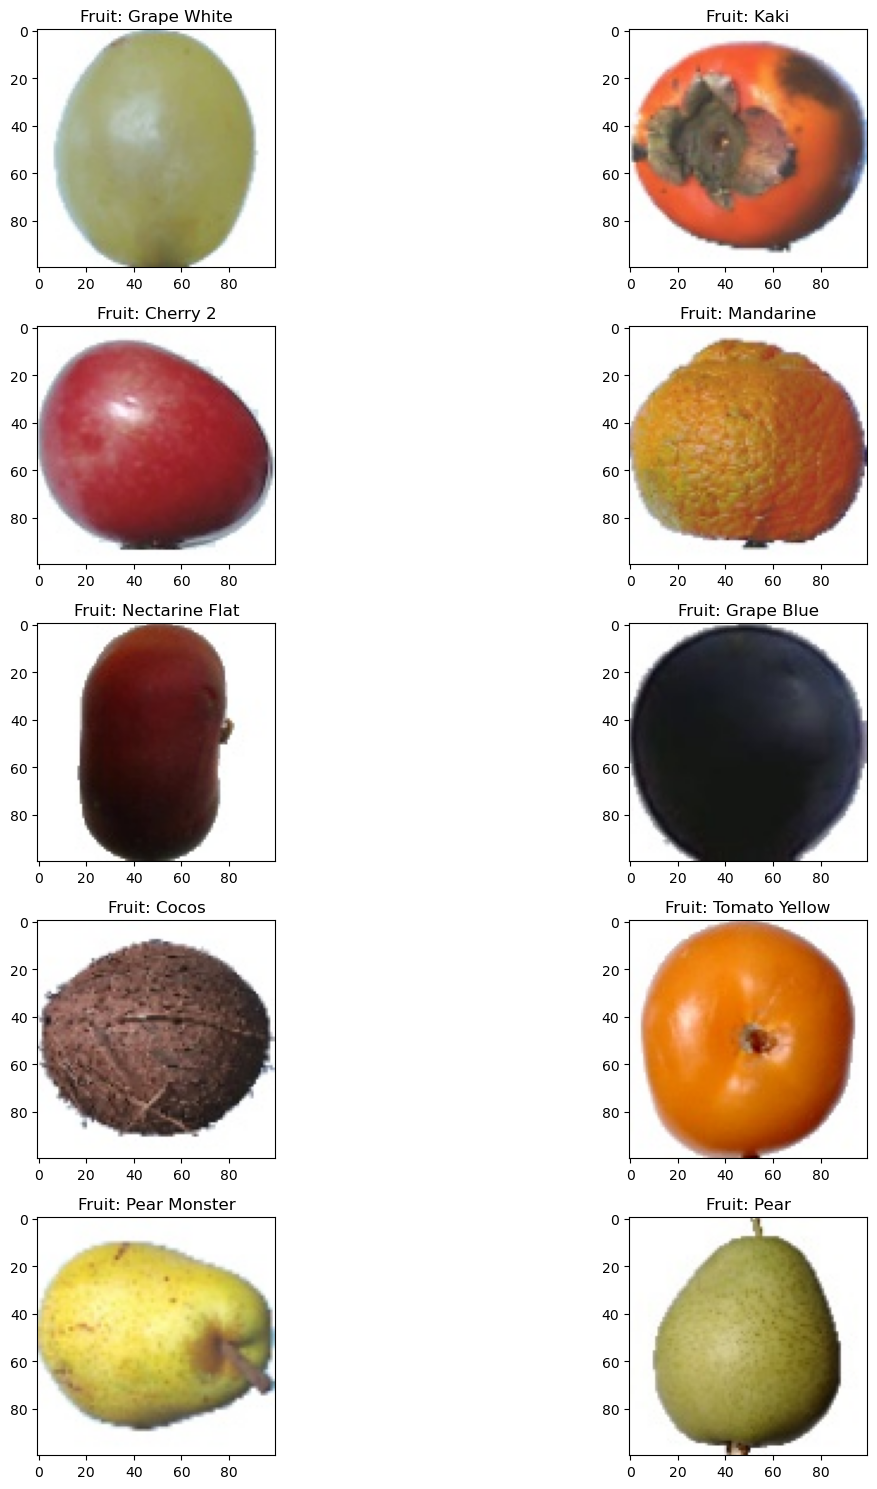

In [28]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range(2):
        l = rd.randint(0, len(Z))
        ax[i,j].imshow(cv2.cvtColor(X[l], cv2.COLOR_BGR2RGB))
        ax[i,j].set_title('Fruit: ' + Z[l])
        
plt.tight_layout()

In [29]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, 131)
X = np.array(X)
X = X/255

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [31]:
np.random.seed(42)
rd.seed(42)
tf.random.set_seed(42)

In [32]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size= (5,5), padding = 'Same', activation='relu', input_shape = (100, 100, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size= (3,3), padding='Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=96, kernel_size=(3,3), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(131, activation='softmax'))

In [33]:
batch_size = 128
epochs = 3

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.1)

In [34]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zoom_range=0.1,
    width_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

In [35]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 96)       0

In [37]:
History = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(x_test, y_test), 
                              verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/3
529/529 [==============================] - 348s 655ms/step - loss: 0.8739 - accuracy: 0.7619 - val_loss: 0.0891 - val_accuracy: 0.9721
Epoch 2/3
529/529 [==============================] - 302s 571ms/step - loss: 0.1253 - accuracy: 0.9609 - val_loss: 0.0822 - val_accuracy: 0.9771
Epoch 3/3
529/529 [==============================] - 245s 464ms/step - loss: 0.0672 - accuracy: 0.9790 - val_loss: 0.0915 - val_accuracy: 0.9716


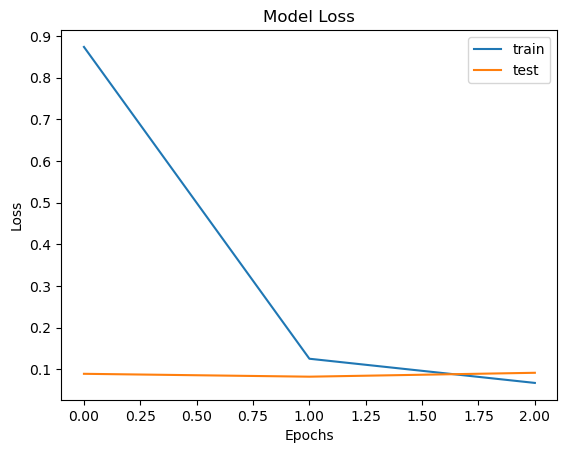

In [38]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## Delete Dataset Folders ##

In [6]:
shutil.rmtree('dataset', ignore_errors=True)
